In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DATA UTILITIES

In [4]:
#NOTE to TA: This filepath has to be changed for you.
df = pd.read_csv('/content/drive/MyDrive/COVID Kaggle Data/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
#Show sum of nullvalues per feature.
df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [6]:
#Show datatypes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [ ]:
#Replace all null values with "unknown".
df.fillna('unknown', inplace=True)
df.isnull().sum()

In [ ]:
print(df['Label_1_Virus_category'].value_counts())
print('='*50)
print(df['Label_2_Virus_category'].value_counts())

In [ ]:
#Separate train data and test data.
train_data = df[df['Dataset_type']=='TRAIN']
test_data = df[df['Dataset_type']=='TEST']
print('Train shape: ',train_data.shape)
print('Test Shape: ',test_data.shape)

In [ ]:
#Show a countplot.
plt.figure(figsize=(10,5))
sns.countplot(train_data['Label_2_Virus_category']);

In [11]:
#Get the path of train and test folders. NOTE to TA: This filepath will have to be changed for you. 
train_img_path = '/content/drive/MyDrive/COVID Kaggle Data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_img_path = '/content/drive/MyDrive/COVID Kaggle Data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

In [ ]:
#Show sample image.
samp_img1 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][0]))
samp_img2 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][22]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1, cmap='gray');
ax[1].imshow(samp_img2, cmap='gray');

In [ ]:
#Sample x-ray image of person with covid-19.
with_covid = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']

#Show sample image.
samp_img1 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[8]))
samp_img2 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[15]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1);
ax[1].imshow(samp_img2);

In [14]:
#Remove pnuemonia with unknown value.
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

In [15]:
#Add a target and class feature.
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

In [16]:
#Get the important features
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

In [ ]:
test_data['Label'].value_counts()

### DATA AUGMENTATION

In [18]:
#Create an imagegenerator for for augmentation.
datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
)

#Function to convert image to array.
def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    #Convert image to array.
    img = image.img_to_array(img) / 255
    return img

In [ ]:
#Read a sample image.
samp_img = read_img(final_train_data['X_ray_image_name'][0],
                                 (224,224),
                                 train_img_path)

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0

#Show augmented images.
for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=6):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(224, 224, 3));
    
    if i == 8:
        break
    i += 1
    
plt.show();

In [ ]:
#Augment the images labeled with covid-19 to balance the data.

corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []

#Create a function for augmentation.
def augment(name):
    img = read_img(name, (224,224), train_img_path)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1

#Apply the function.
corona_df['X_ray_image_name'].apply(augment)

In [ ]:
#Extract the image from trainig data and test data: then convert it to an array.
train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (224,224), train_img_path)))
test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (224,224), test_img_path)))

In [ ]:
print(len(train_arrays))
print(len(test_arrays))

In [23]:
#Concatenate the training data labels and the labels for augmented images.
y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_corona_augmented), dtype=np.int64)))

### CONVERT ALL THE DATA TO TENSORS

In [24]:
train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays), np.array(with_corona_augmented))))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)

### CREATE A TENSOR DATASET

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

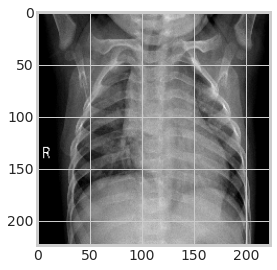

In [26]:
for i,l in train_dataset.take(1):
    plt.imshow(i);

### GENERATE BATCHES

In [27]:
BATCH_SIZE = 16
BUFFER = 1000

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

for i,l in train_batches.take(1):
    print('Train Shape per Batch: ',i.shape);
for i,l in test_batches.take(1):
    print('Test Shape per Batch: ',i.shape);

Train Shape per Batch:  (16, 224, 224, 3)
Test Shape per Batch:  (16, 224, 224, 3)


### TRANSFER LEARNING NASNetMobile



In [ ]:
#Define input shape.
INPUT_SHAPE = (224,224,3) 

#Get the pretrained model.
base_model = tf.keras.applications.NASNetMobile(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Freeze all layers of base_model.
base_model.trainable = False
base_model.summary()

In [29]:
#Verify the output shape.
for i,l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([16, 7, 7, 1056])

### ADD LAYERS FOR IMAGE CLASSIFICATION

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Layers.GlobalAveragePooling2D())
model.add(Layers.Dense(128))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

In [38]:
#Add an earlystopping callback to stop the training if the model is not learning anymore.
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### FIT AND PREDICT THE MODEL

In [ ]:
model.fit(train_batches, epochs=10, validation_data=test_batches, callbacks = [callbacks])

In [36]:
#Predict the test data
pred = model.predict_classes(np.array(test_arrays))

In [37]:
#Print a classification report.
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data['target'], pred.flatten()))

              precision    recall  f1-score   support

           0       0.46      0.98      0.63       234
           1       0.97      0.32      0.48       390

    accuracy                           0.57       624
   macro avg       0.72      0.65      0.56       624
weighted avg       0.78      0.57      0.54       624

